# 📓 Preprocessamento dos dados de Fetal Health

Este notebook simplifica e documenta os passos de pré-processamento usados antes de treinar modelos de classificação para o status fetal (healthy / suspect / pathological).
O foco: ser didático, conciso e seguir a mesma narrativa do `notebook.ipynb` (problema -> inspeção -> tratamento -> saída).
Escopo: somente pré-processamento e tratamento de dados — NÃO inclui modelagem.

## Problema (problemática)

Temos sinais de cardiotocografia (CTG) por registro e queremos classificar o estado fetal em 3 classes.
Pré-processamento é crítico porque:
- variáveis têm escalas muito diferentes (ex.: acelerations vs baseline),
- podem existir outliers que distorcem modelos sensíveis,
- precisamos garantir reprodutibilidade e um CSV pronto para modelos downstream.

Escopo deste notebook: somente pré-processamento e saída de um CSV para uso posterior em modelagem.

In [1]:
import sys
print(sys.executable)


c:\Users\Thiago Amaral\OneDrive\Documentos\Github\Fetal-Health-Classification\.venv\Scripts\python.exe


In [2]:
# Importações essenciais e configurações visuais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
sns.set(style="whitegrid")
%matplotlib inline
# Para reprodutibilidade de procedimentos que usam aleatoriedade (se houver)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Carregar dados e checar rapidamente formato e target
df = pd.read_csv("fetal_health.csv")
print('shape:', df.shape)
display(df.head())
print('\nDistribuição do target:')
print(df['fetal_health'].value_counts(normalize=True).round(3))

shape: (2126, 22)


,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0



Distribuição do target:
fetal_health
1.0    0.778
2.0    0.139
3.0    0.083
Name: proportion, dtype: float64


In [4]:
# Informações sumarizadas: tipos, NA e estatísticas básicas
print('Info:')
df.info()  # mostra tipos e não retorna DataFrame quando exibido no Jupyter
print('\nDescrição:')
display(df.describe().T)
print('\nNulos por coluna:')
display(df.isnull().sum())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variabi

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000



Nulos por coluna:


baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

## Correlações e inspeção inicial
A matriz de correlação ajuda a identificar variáveis altamente correlacionadas que podem influenciar modelos lineares e interpretar redundância.

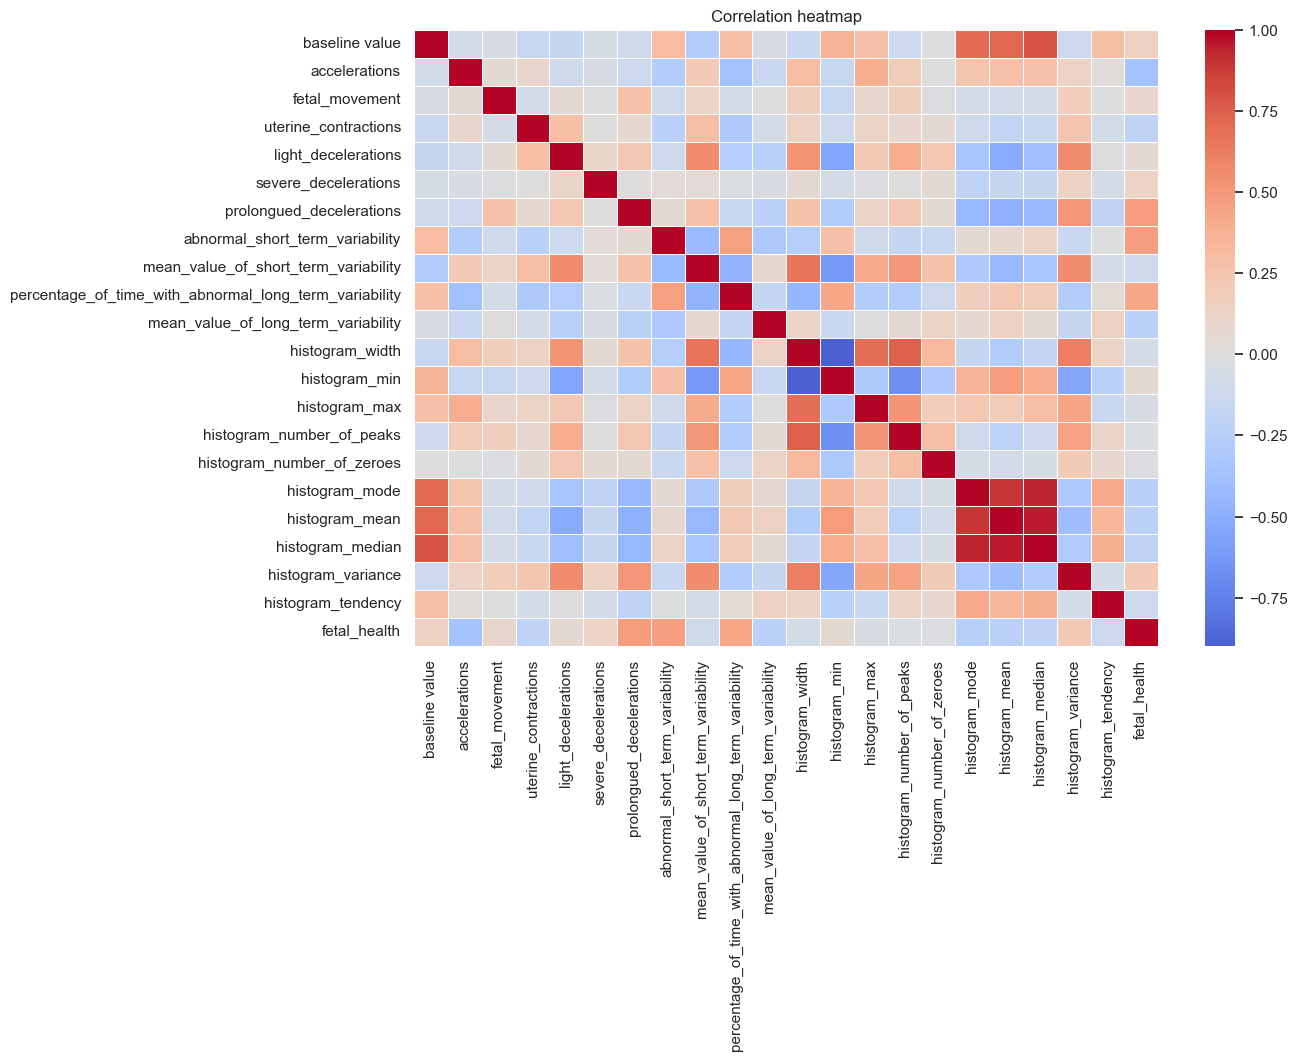

In [5]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlation heatmap')
plt.show()

## Tratamento de outliers (forma simples e explicada)
Usamos clipping por IQR — preserva forma da distribuição mas limita extremos. É rápido, interpretável e suficiente para muitos modelos.

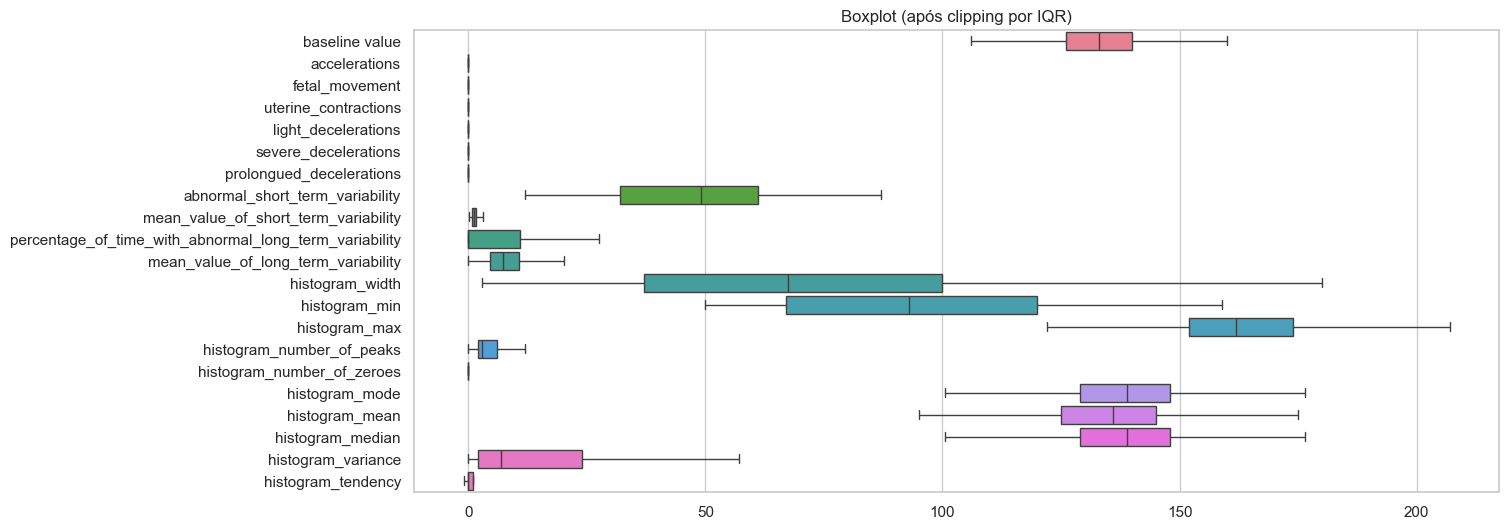

In [6]:
def clip_iqr(df, cols, k=1.5):
    """Clipa valores fora dos limites [Q1 - k*IQR, Q3 + k*IQR] por coluna (vetorizado).
    Recebe um DataFrame e uma lista/Index de colunas numéricas e devolve o subset clippado."""
    q1 = df[cols].quantile(0.25)
    q3 = df[cols].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    # aplica clipping por coluna de forma vetorizada (mais rápido que loops)
    return df[cols].clip(lower=lower, upper=upper, axis=1)

num_cols = df.select_dtypes(include=[np.number]).columns.drop('fetal_health')
df[num_cols] = clip_iqr(df, num_cols)

# Mostrar boxplot após tratamento (visualmente rápido)
plt.figure(figsize=(14,6))
sns.boxplot(data=df[num_cols], orient='h')
plt.title('Boxplot (após clipping por IQR)')
plt.show()

In [7]:
# Separar features e target (escopo: apenas preparar features; não treinar modelos aqui)
X = df.drop('fetal_health', axis=1)
y = df['fetal_health']
# Padronização: zero mean e unit variance — útil para modelos sensíveis à escala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_processed = pd.DataFrame(X_scaled, columns=X.columns)
df_processed['fetal_health'] = y.values
display(df_processed.head())

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,-1.352220,-0.827841,-0.629461,-1.482802,-0.686717,0.0,0.0,1.513190,-1.037551,2.027063,...,-1.068562,-2.180415,-0.708942,0.0,-1.220453,0.147407,-1.219134,2.278906,1.112980,2.0
1,-0.132526,0.740778,-0.629461,0.554863,0.501853,0.0,0.0,-1.744751,1.038162,-0.646799,...,-0.865539,1.968564,0.673820,0.0,0.210720,0.080856,0.128623,-0.197164,-0.524526,1.0
2,-0.030884,-0.043532,-0.629461,1.234084,0.501853,0.0,0.0,-1.802928,1.038162,-0.646799,...,-0.865539,1.968564,0.328130,0.0,0.210720,0.014306,-0.013246,-0.142140,-0.524526,1.0
3,0.070757,-0.043532,-0.629461,1.234084,0.501853,0.0,0.0,-1.802928,1.427358,-0.646799,...,-1.373097,0.355072,2.402272,0.0,-0.061884,-0.052245,-0.084181,-0.142140,1.112980,1.0
4,-0.132526,1.002214,-0.629461,1.234084,-0.686717,0.0,0.0,-1.802928,1.427358,-0.646799,...,-1.373097,0.355072,1.710891,0.0,-0.061884,0.080856,-0.013246,-0.252188,1.112980,1.0


In [8]:
# Salvar dataset processado pronto para treino
out_path = 'fetal_health_processed.csv'
df_processed.to_csv(out_path, index=False)
print(f'✔ Arquivo salvo: {out_path} (linhas: {df_processed.shape[0]}, colunas: {df_processed.shape[1]})')

✔ Arquivo salvo: fetal_health_processed.csv (linhas: 2126, colunas: 22)


## Conclusão (foco em tratamento de dados)
- Este notebook realiza: inspeção básica, clipping por IQR e padronização das features.
- Produto final: `fetal_health_processed.csv` pronto para uso em modelagem externa.
- Próximos passos (apenas sugestões de tratamento de dados): balanceamento de classes (se necessário), engenharia/seleção de features, detecção mais avançada de outliers (ex.: isolamento ou métodos robustos).
- Observação: não inclui passos de modelagem; mantenho o escopo restrito a pré-processamento.